In [27]:
# import libraries which can read h5 files
import h5py
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm

from scipy import signal
import os

# change to inline plotting
%matplotlib inline

In [4]:
def moving_average_fast(x, w):
    x = np.mean(x.reshape(x.shape[0], -1, w), -1)
    return x

def taper(data, fs, half_length):  # half_length is in seconds
    Hann = signal.hann(int(half_length * fs * 2.0) + 1)
    length = int(Hann.shape[0] / 2.0)
    data_taper = data
    taper_function = np.ones(data.shape[1])
    taper_function[0:length] = Hann[0:length]
    taper_function[data.shape[1] - length:data.shape[1]] = Hann[Hann.shape[0] - length:Hann.shape[0]]

    for i in range(data.shape[0]):
        data_taper[i, :] = np.multiply(data[i, :], taper_function)
    return data_taper

def filter(data, f, fmin, fmax):
    sos = signal.iirfilter(4, [fmin, fmax], fs=f, btype='band', analog=False, ftype='butter', output='sos')
    data_filter = signal.sosfiltfilt(sos, data)
    return data_filter

In [19]:
def clean_file(data): # sensors x time
    delta = 0.004  # [s] data sampling interval5
    time = np.arange(0, data.shape[1] * delta, delta)  # time series for the data

    ### Preprocessing the data;
    ## Fmin and Fmax can be changed;
    ## filter range can be 0.1-50 Hz; Here 1-10 Hz is just an example
    F = 1 / delta  # [Hz] data sampling rate
    Fmin = 1  # [Hz] bandpass min freq
    Fmax = 10  # [Hz] bandpass max freq
    Taper_window = 2.0 # 2 seconds Hanning taper window

    data = np.gradient(data, axis=1) / delta  # differentiate data converting strain waveforms to strain rate
    data = signal.detrend(data, type='linear')  # remove linear trend
    data = signal.detrend(data, type='constant')  # remove mean
    data = taper(data, F, Taper_window)  # taper the waveforms with a Hanning filter [optional; taper is for the next bandpass]
    data = filter(data, F, Fmin, Fmax)  # bandpass filter the data [optional]

    return data

In [21]:
def read_file(file_name, resample_rate=1, split_rate=40): # Read 3600s data, split 40 times, each 90s
    f = h5py.File(f'/data/rech/dingqian/data_das/DAS/chao_new/{file_name}', 'r')
    data = f['Data'][:]
    print(data.shape)
    # data = data[::resample_rate,:]
    data = clean_file(data)
    print(data.shape)

    # data_resample = data[::resample_rate,:].T # resample per 10 stations
    data = data.T

    # Only filter for building the dataset.

    # data -= np.median(data, axis=1, keepdims=True)
    # data -= np.mean(data, axis=0)
    # data /= np.std(data, axis=0)
    
    data_splits = np.split(data, split_rate, axis=0) # to 90 seconds splits

    return data_splits

def read_catalog(file_name):
    # read file using open
    with open(f'data/{file_name}', 'r') as f:
        catalog = f.readlines()
    return catalog

In [35]:
def file_to_npz(data_splits, file_name, set_name, starting_time, interval, catalog, save=False):
    npz_list = []
    has_list = []
    
    for i, data in enumerate(tqdm(data_splits)):
        meta = {}
        meta['data'] = data.astype(np.float64) # (9000, 3260)
        meta['time_start'] = starting_time

        ending_time = starting_time + timedelta(seconds=interval*data.shape[0])

        # save meta to npz
        file_prefix = file_name.split('.')[0]

        if save:
            save_path = f'/data/rech/dingqian/data_das/DAS/chao_new/splits/{set_name}/{file_prefix}-{i}.npz'
            print(save_path)
            # check if save_path does not exists, then create the path with makedirs
            if not os.path.exists(os.path.dirname(save_path)):
                os.makedirs(os.path.dirname(save_path))

            np.savez_compressed(save_path, **meta)
        
        # check if there is any time in catalog between starting_time and ending_time
        for cat_time in catalog:
            # print(cat_time, starting_time, ending_time)
            if starting_time <= cat_time <= ending_time:
                # meta['catalog'] is the number of seconds between starting_time and cat_time divided by interval
                meta['catalog'] = (cat_time - starting_time).seconds / interval
                has_list.append(i)

        npz_list.append(meta)
        starting_time = ending_time
    
    return npz_list, has_list

In [14]:
def plot_data(data):

    # data = data[:, 200:400]

    data -= np.median(data, axis=1, keepdims=True)
    # data -= np.mean(data, axis=0)
    # data /= np.std(data, axis=0)

    plt.figure(figsize=(10, 8))
    plt.imshow(data.T, vmin=-2.0, vmax=2.0, cmap="seismic", aspect='auto')
    plt.gca().invert_yaxis()
    plt.xlabel("Time")
    plt.ylabel("Station")

In [23]:
def extract_starting_time_str(file_name):
    file_prefix = file_name.split('.')[0]
    time_str = file_prefix
    time_ret = datetime.strptime(time_str, '%Y%m%d%H')
    return time_ret

In [36]:
file_name = '2020062417.h5' # 100 Hz
set_name = 'train_npz'
data_splits = read_file(file_name) # segment in 90 seconds, size in (9000, 3260)
starting_time = extract_starting_time_str(file_name)
interval = 0.01

npz_list, has_list = file_to_npz(data_splits, file_name, set_name, starting_time, interval, [], save=True)

(1250, 900000)
(1250, 900000)


  0%|          | 0/40 [00:00<?, ?it/s]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-0.npz


  2%|▎         | 1/40 [00:07<05:09,  7.94s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-1.npz


  5%|▌         | 2/40 [00:17<05:28,  8.64s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-2.npz


  8%|▊         | 3/40 [00:26<05:24,  8.78s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-3.npz


 10%|█         | 4/40 [00:34<05:18,  8.84s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-4.npz


 12%|█▎        | 5/40 [00:44<05:14,  8.99s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-5.npz


 15%|█▌        | 6/40 [00:53<05:07,  9.05s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-6.npz


 18%|█▊        | 7/40 [01:02<04:57,  9.01s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-7.npz


 20%|██        | 8/40 [01:11<04:47,  8.98s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-8.npz


 22%|██▎       | 9/40 [01:20<04:38,  8.98s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-9.npz


 25%|██▌       | 10/40 [01:29<04:28,  8.96s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-10.npz


 28%|██▊       | 11/40 [01:38<04:20,  8.97s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-11.npz


 30%|███       | 12/40 [01:47<04:10,  8.96s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-12.npz


 32%|███▎      | 13/40 [01:56<04:03,  9.01s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-13.npz


 35%|███▌      | 14/40 [02:05<03:54,  9.00s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-14.npz


 38%|███▊      | 15/40 [02:14<03:44,  9.00s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-15.npz


 40%|████      | 16/40 [02:23<03:35,  8.99s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-16.npz


 42%|████▎     | 17/40 [02:31<03:25,  8.92s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-17.npz


 45%|████▌     | 18/40 [02:40<03:16,  8.93s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-18.npz


 48%|████▊     | 19/40 [02:50<03:11,  9.10s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-19.npz


 50%|█████     | 20/40 [02:59<03:03,  9.19s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-20.npz


 52%|█████▎    | 21/40 [03:08<02:52,  9.09s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-21.npz


 55%|█████▌    | 22/40 [03:17<02:42,  9.05s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-22.npz


 57%|█████▊    | 23/40 [03:26<02:34,  9.07s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-23.npz


 60%|██████    | 24/40 [03:35<02:26,  9.13s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-24.npz


 62%|██████▎   | 25/40 [03:44<02:16,  9.09s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-25.npz


 65%|██████▌   | 26/40 [03:53<02:06,  9.04s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-26.npz


 68%|██████▊   | 27/40 [04:02<01:57,  9.04s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-27.npz


 70%|███████   | 28/40 [04:11<01:48,  9.04s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-28.npz


 72%|███████▎  | 29/40 [04:21<01:40,  9.10s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-29.npz


 75%|███████▌  | 30/40 [04:29<01:30,  9.02s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-30.npz


 78%|███████▊  | 31/40 [04:38<01:20,  9.00s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-31.npz


 80%|████████  | 32/40 [04:47<01:11,  8.98s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-32.npz


 82%|████████▎ | 33/40 [04:56<01:02,  8.97s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-33.npz


 85%|████████▌ | 34/40 [05:05<00:53,  8.89s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-34.npz


 88%|████████▊ | 35/40 [05:14<00:44,  8.92s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-35.npz


 90%|█████████ | 36/40 [05:23<00:35,  8.95s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-36.npz


 92%|█████████▎| 37/40 [05:32<00:26,  8.95s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-37.npz


 95%|█████████▌| 38/40 [05:41<00:17,  8.96s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-38.npz


 98%|█████████▊| 39/40 [05:50<00:08,  8.96s/it]

/data/rech/dingqian/data_das/DAS/chao_new/splits/train_npz/2020062417-39.npz


100%|██████████| 40/40 [05:59<00:00,  8.98s/it]


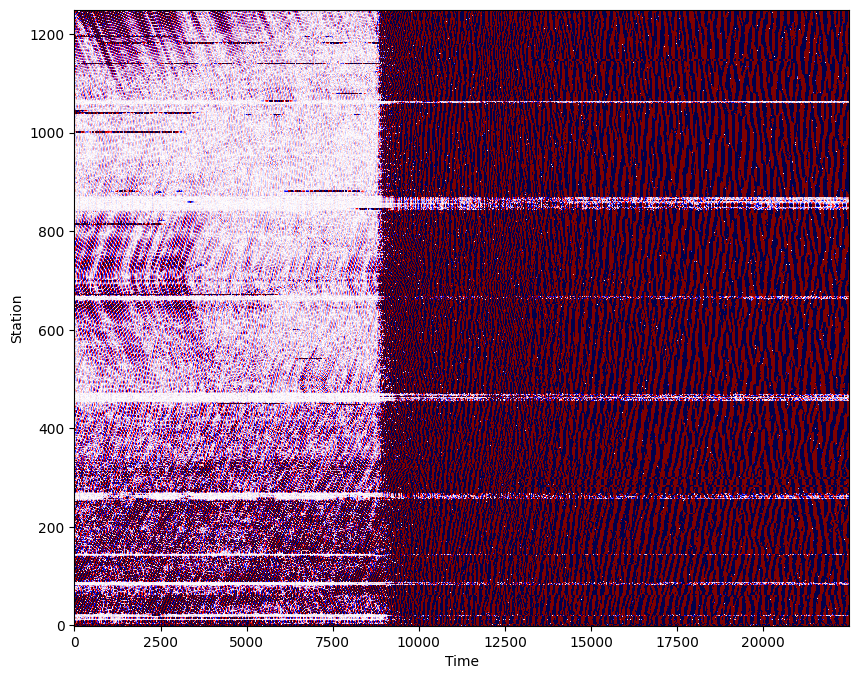

In [40]:
plot_data(npz_list[27]['data'])

In [ ]:
# 2449/90=